# Homework 1—Introduction to MLOps

In [152]:
import pandas as pd

In [164]:
jan_2023_data = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'
feb_2023_data = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet'
jan_df = pd.read_parquet(jan_2023_data)
feb_df = pd.read_parquet(feb_2023_data)
jan_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [ ]:
# Remove outliers
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

### Q1. Read the data for January. How many columns are there?

In [145]:
columns_count = jan_df.columns.size
print(f"Number of columns in January data: {columns_count}")

Number of columns in January data: 19


### Q2. What's the standard deviation of the trips duration in January?

In [146]:
jan_df['duration'] = jan_df['tpep_dropoff_datetime'] - jan_df['tpep_pickup_datetime']
jan_df.duration = jan_df.duration.apply(lambda x: x.total_seconds() / 60)
std = jan_df['duration'].std()
print(f"Standard deviation of trip duration in January: {std:.2f} minutes")

Standard deviation of trip duration in January: 42.59 minutes


### Q3. What fraction of the records left after you dropped the outliers?

In [148]:
# Jan data size before dropping outliers
size_b4_outliers = jan_df.shape[0]
print('Size before dropping outliers:', size_b4_outliers)

Size before dropping outliers: 3066766


In [149]:
# Drop outliers
jan_df = jan_df[(jan_df['duration'] >= 1) & (jan_df['duration'] <= 60)]
size_after_outliers = jan_df.shape[0]
print('Size after dropping outliers:', size_after_outliers)

Size after dropping outliers: 3009173


In [150]:
# Fraction of the records left after you dropped the outliers.
fraction = size_after_outliers/size_b4_outliers
print('Fraction of records left after dropping outliers:', fraction*100, '%')

Fraction of records left after dropping outliers: 98.1220282212598 %


### Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
Fit a dictionary vectorizer
Get a feature matrix from it
What's the dimensionality of this matrix (number of columns)?

In [151]:
# Convert categorical columns to string
categorical = ['PULocationID', 'DOLocationID']
numerical = ['duration']

jan_df[categorical] = jan_df[categorical].astype(str)
list_of_dicts = jan_df[categorical].to_dict(orient='records')

In [154]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer()

In [156]:
feature_matrix = dv.fit_transform(list_of_dicts)
feature_matrix_array = feature_matrix.toarray()
dim = feature_matrix_array.shape

print(f"Dimensionality of the feature matrix: {dim[1]} columns")

Dimensionality of the feature matrix: 515 columns


### Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters, where duration is the response variable
Calculate the RMSE of the model on the training data
What's the RMSE on train?

### Data Exploration

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

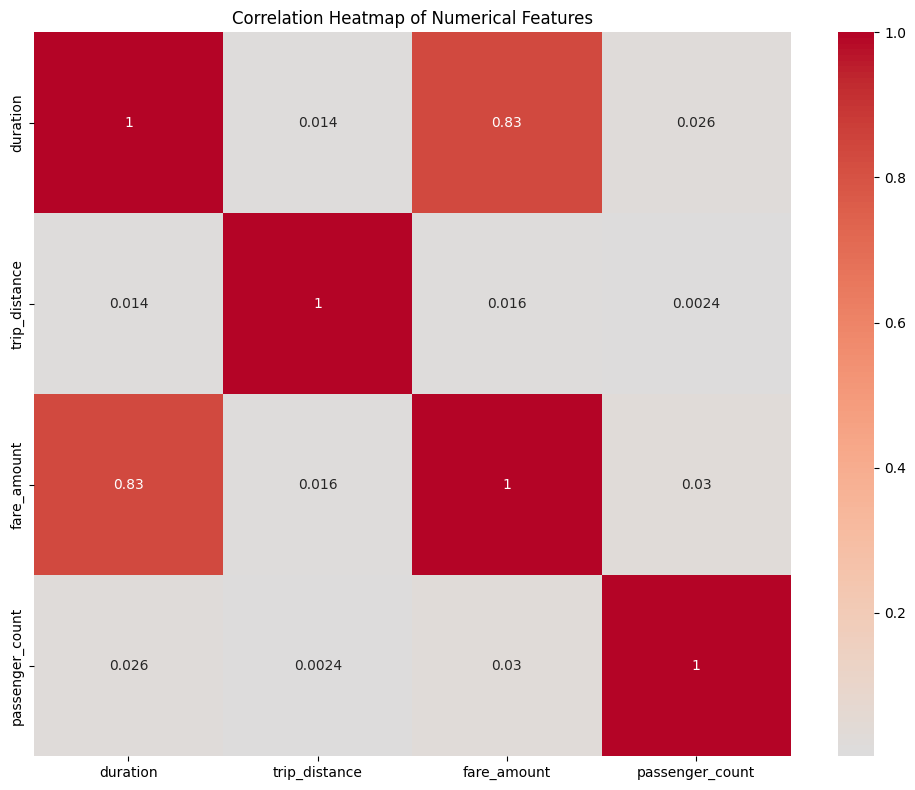

In [159]:
numerical_cols = ['duration', 'trip_distance', 'fare_amount', 'passenger_count']
correlation_matrix = jan_df[numerical_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

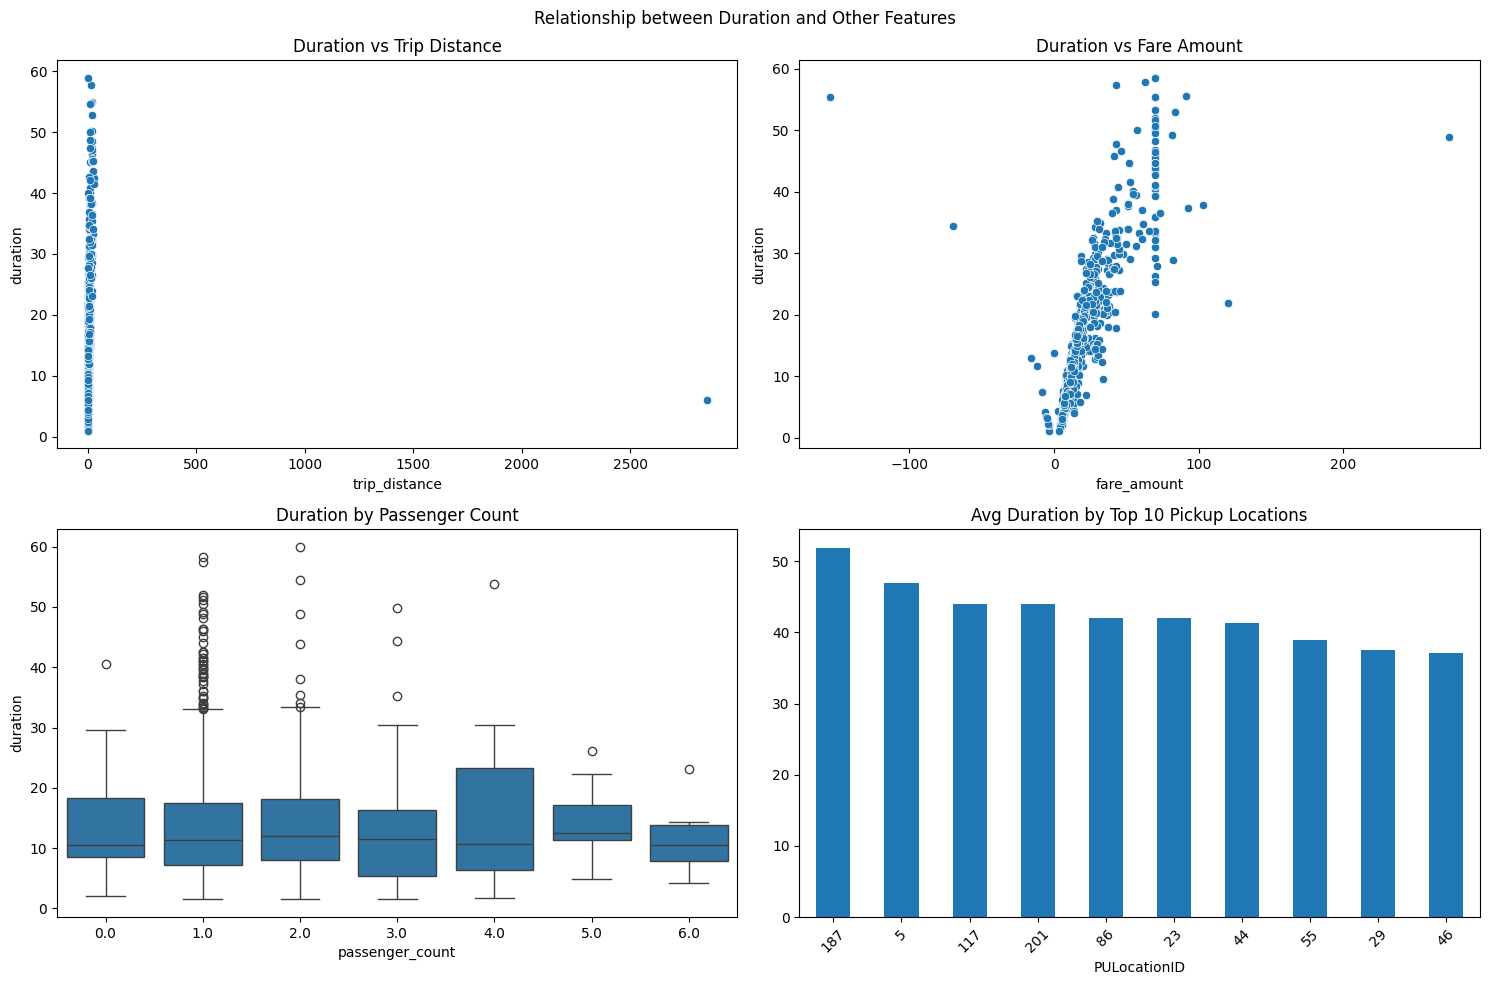

In [163]:
# Scatter plots with key numerical features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Relationship between Duration and Other Features')

sns.scatterplot(data=jan_df.sample(1000), x='trip_distance', y='duration', ax=axes[0, 0])
axes[0, 0].set_title('Duration vs Trip Distance')

sns.scatterplot(data=jan_df.sample(1000), x='fare_amount', y='duration', ax=axes[0, 1])
axes[0, 1].set_title('Duration vs Fare Amount')

sns.boxplot(data=jan_df.sample(1000), x='passenger_count', y='duration', ax=axes[1, 0])
axes[1, 0].set_title('Duration by Passenger Count')

# Average duration by location
location_duration = jan_df.groupby('PULocationID')['duration'].mean().sort_values(ascending=False)
location_duration.head(10).plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Avg Duration by Top 10 Pickup Locations')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Duration Analysis Based on Visualizations

1. Correlation Analysis:
- Duration shows strong positive correlation (0.83) with fare amount
- Weak correlations with trip distance (0.01) and passenger count (0.02)
- Suggests fare amount is the strongest predictor of trip duration

2. Trip Distance vs Duration:
- Exhibits positive but noisy relationship
- High variance indicates same distance trips can have very different durations
- Likely influenced by traffic conditions and time of day
- Some outliers show short distances with long durations (traffic/waiting time)

3. Fare Amount vs Duration:
- Strong linear relationship validates high correlation coefficient
- More consistent and less scattered than distance relationship
- Better predictor for trip duration modeling
- Reflects time-based fare calculation

4. Passenger Count Impact:
- Similar median durations across passenger counts
- Large number of outliers in each category
- Passenger count appears to have minimal impact on trip duration
- Not a strong predictive feature

5. Location Analysis:
- Significant variation in average duration by pickup location
- Some locations consistently show longer average trip times
- Geographic patterns likely reflect infrastructure and traffic conditions
- Location features important for duration prediction

6. Prediction Distribution:
- Model captures overall duration distribution shape
- Right-skewed pattern shows predominance of shorter trips
- Some underprediction of longer duration trips
- Most trips concentrated in 5-15 minute range

## Training the Model on January Data

In [165]:
training_data = read_dataframe(jan_2023_data)
training_data[categorical] = training_data[categorical].astype(str)

In [167]:
training_dicts = training_data[categorical].to_dict(orient='records')
X_train = dv.fit_transform(training_dicts)
X_train.shape

(3009173, 515)

In [169]:
target = 'duration'
y_train = training_data[target].values

In [171]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [172]:
lr.fit(X_train, y_train)

LinearRegression()

In [174]:
y_pred = lr.predict(X_train)

In [176]:
import numpy as np
from sklearn.metrics import mean_squared_error
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"RMSE on training data: {rmse:.3f} minutes")

RMSE on training data: 7.649 minutes


### Q6. Evaluating the model
Now let's apply this model to the validation dataset (February 2023).

What's the RMSE on validation?

In [177]:
training_data = read_dataframe(jan_2023_data)
validation_data = read_dataframe(feb_2023_data)
validation_data[categorical] = validation_data[categorical].astype(str)

train_dicts = training_data[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

validation_dicts = validation_data[categorical].to_dict(orient='records')
X_validation = dv.transform(validation_dicts)

In [178]:
target = 'duration'
y_train = training_data[target].values
y_validation = validation_data[target].values

In [179]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [180]:
y_pred = lr.predict(X_validation)

In [181]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
print(f"RMSE on validation data: {rmse:.3f} minutes")

RMSE on validation data: 7.812 minutes


/var/folders/40/jk2lwm8160l7zl5ccrtfvn940000gn/T/ipykernel_2811/1047109615.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction', hist=False)
/var/folders/40/jk2lwm8160l7zl5ccrtfvn940000gn/T/ipykernel_2811/1047109615.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


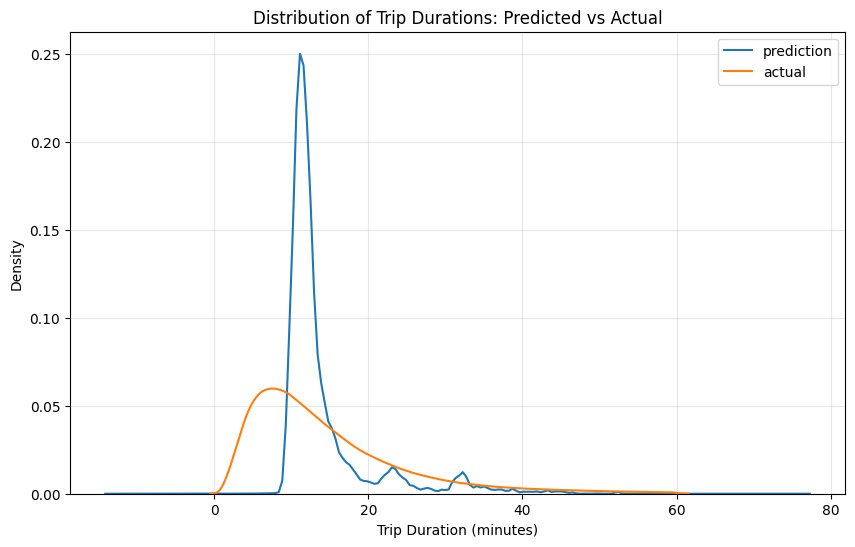

In [182]:
plt.figure(figsize=(10, 6))
sns.distplot(y_pred, label='prediction', hist=False)
sns.distplot(y_val, label='actual', hist=False)
plt.title('Distribution of Trip Durations: Predicted vs Actual')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

The graph shows two distribution plots comparing the predicted trip durations versus actual trip durations:

- Blue line (prediction): Distribution of predicted trip durations from the linear regression model
- Orange line (actual): Distribution of actual trip durations from the training data

Key observations:
1. Both distributions are right-skewed, meaning there are more shorter trips than longer ones
2. The model's predictions follow a similar overall shape to the actual data, suggesting it has captured the general pattern
3. The predicted distribution appears slightly smoother than the actual distribution
4. Most trips fall in the 5-15 minute range, with a peak around 7-8 minutes
5. There are fewer trips with longer durations (>30 minutes) in both distributions